<a href="https://colab.research.google.com/github/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-4.1D/SIT_796_Task_4_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils
import gym
from gym import Env
from gym.spaces import Discrete, Box
from gym.envs.toy_text import discrete

In [20]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    
    total_reward = 0
    episode_rewards = []
    
    for episode in range(n_episodes):
        
        terminated = False        
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state

            episode_rewards.append((episode, total_reward))
                
    average_reward = total_reward / n_episodes
    
    return total_reward, average_reward, episode_rewards


In [21]:
class CustomEnv(Env):
    def __init__(self):
        self.action_space = Discrete(3)
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        self.state = 38 + random.randint(-3,3)
        self.shower_length = 60

        self.P = {s: {a: [] for a in range(3)} for s in range(101)}
        self.I = np.matrix([[0.3333, 0.333, 0.3333]])
        self.T = np.matrix([[0.6, 0.2, 0.2],
                      [0.5, 0.3, 0.2],
                      [0.4, 0.3, 0.4]])
        self.T1 = self.I * self.T
        
    def step(self, action):
 
        self.state += action -1 
        self.shower_length -= 1 
        
        if self.state >=37 and self.state <=39: 
            reward =1 
            T1 = self.I * self.T
        else: 
            reward = -1 
            T1 = self.T1 * self.T
        
        if self.shower_length <= 0: 
            done = True
        else:
            done = False          
        
        self.T1 = T1        
        self.P[self.state][action].append((self.T1.item(0) , reward, self.state))

        info = {}
        
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        self.state = 38 + random.randint(-3,3)        
        self.shower_length = 60 
        return self.state

In [22]:
import numpy as np
import gym
#env = CustomEnv()
env = gym.make('FrozenLake-v0')
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, [], random = True)

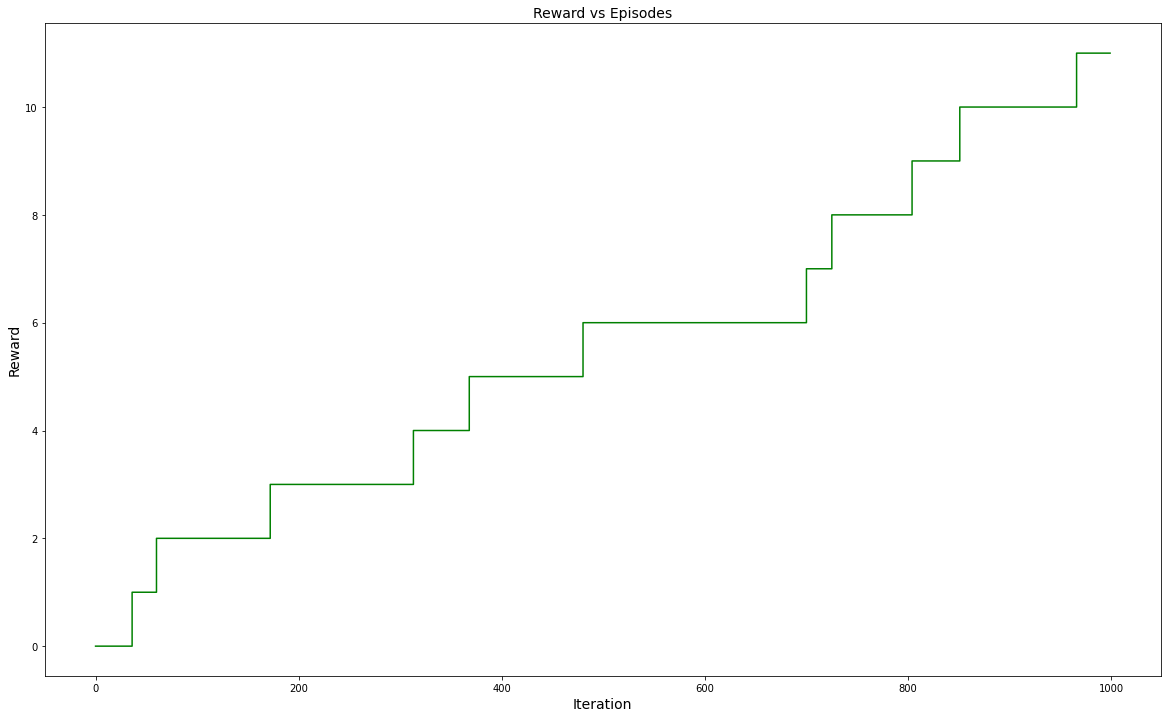

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()

Optimal Policy Iteration and Evaluation

In [24]:
def policy_eval(env, policy, V, discount_factor):

    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [25]:
def one_step_lookahead(env, state, V , discount_factor = 0.90):    
    action_values = np.zeros(env.nA)
    
    for action in range(env.nA):
        for probablity, next_state, reward, info in env.P[state][action]:
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [26]:
def update_policy(env, policy, V, discount_factor):    
    
    for state in range(env.nS):
        action_values = one_step_lookahead(env, state, V, discount_factor)        
        policy[state] =  np.argmax(action_values)
        
    return policy

In [27]:
def policy_iteration(env, discount_factor = 0.90, max_iteration = 1000):

    V = np.zeros(env.nS)    
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        V = policy_eval(env, policy, V, discount_factor)        
        policy = update_policy(env, policy, V, discount_factor)
        
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
                        
    return V, policy

In [28]:
opt_V2, opt_policy2 = policy_iteration(env, discount_factor = 0.90, max_iteration = 10000)
print('Optimal Value function: ')
print(opt_V2.reshape((4, 4)))
print('Final Policy: ')
print(opt_policy2)

policy converged at iteration 31
Optimal Value function: 
[[0.06464143 0.05783154 0.07179787 0.05296771]
 [0.0879758  0.         0.11078945 0.        ]
 [0.14227368 0.24534255 0.29810017 0.        ]
 [0.         0.37836242 0.63818919 0.        ]]
Final Policy: 
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [29]:
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, opt_policy2, random = False)

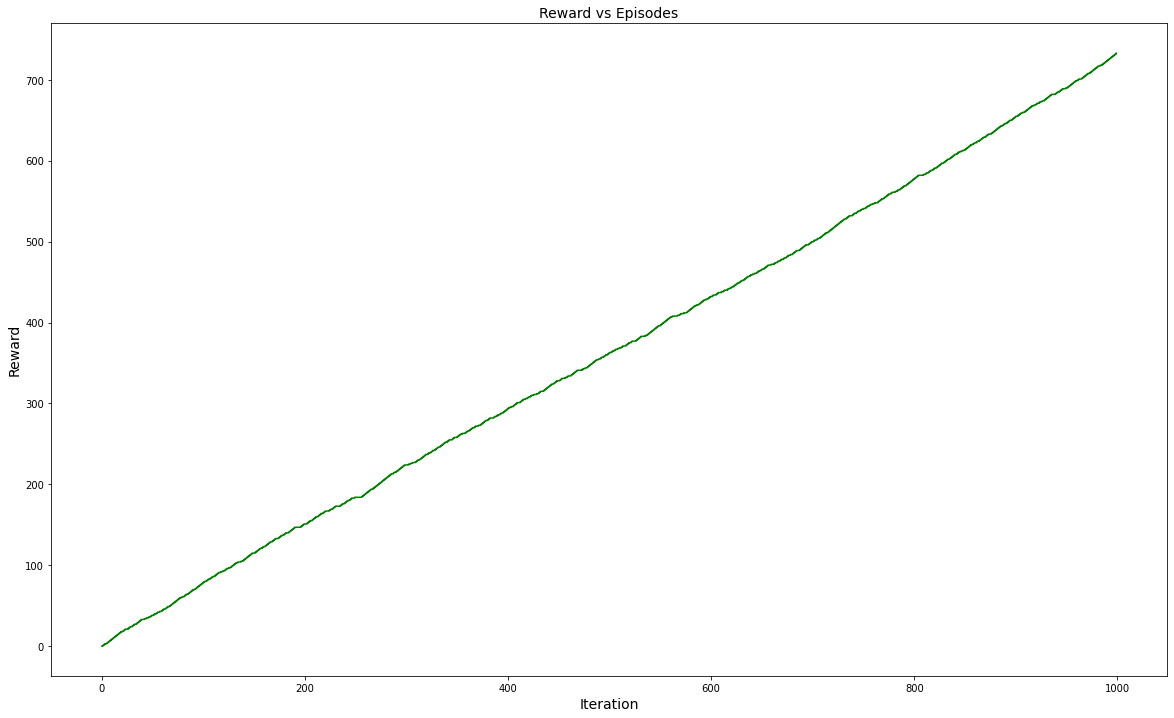

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()

Value Iteration

In [31]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):

    V = np.zeros(env.nS)
    
    for i in range(max_iteration):
        prev_v = np.copy(V) 
        for state in range(env.nS):
            
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            best_action_value = np.max(action_values)
                        
            V[state] =  best_action_value
                    
        if i % 10 == 0:            
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break    
    
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

In [32]:
opt_V, opt_Policy = value_iteration(env, max_iteration = 1000)
print('Optimal Value function: ')
print(opt_V.reshape((4, 4)))
print('Final Policy: ')
print(opt_Policy)

Value converged at iteration 341
Optimal Value function: 
[[0.78538826 0.77836049 0.77368481 0.7713498 ]
 [0.78775777 0.         0.50562724 0.        ]
 [0.79250312 0.79963699 0.74472318 0.        ]
 [0.         0.86409247 0.93114742 0.        ]]
Final Policy: 
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [33]:
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, opt_Policy, random = False)

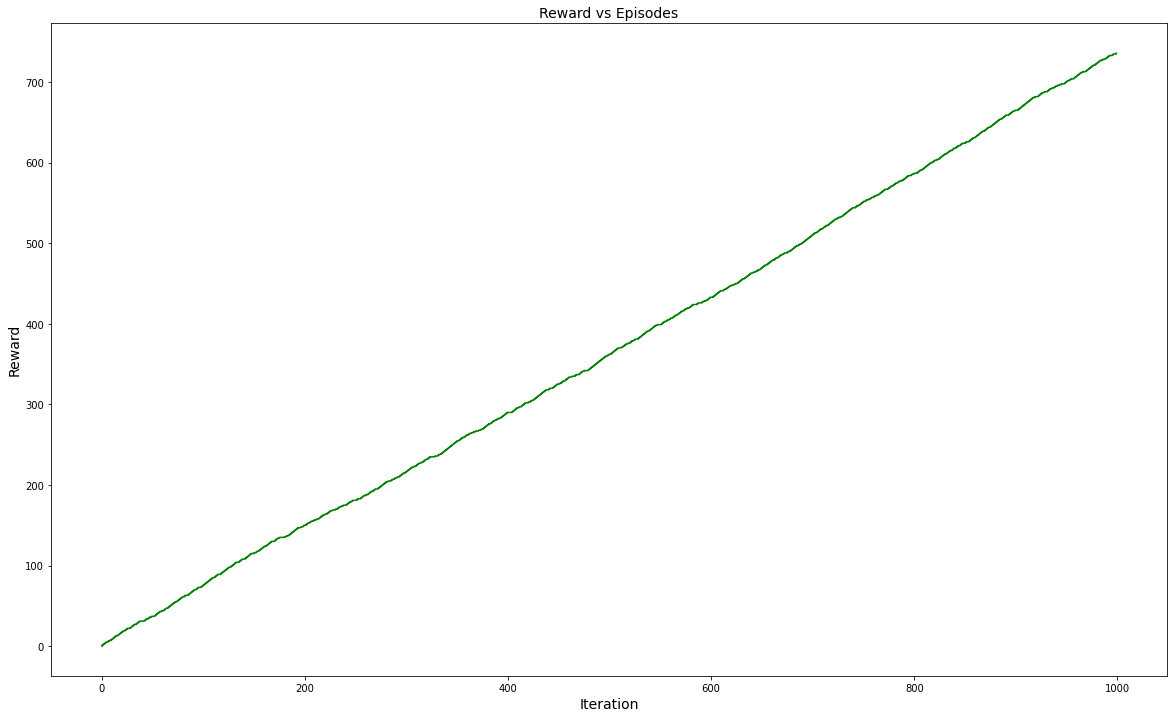

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()